In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import matthews_corrcoef
import numpy as np
import pandas as pd

In [2]:
def create_one_hot_sets(dataset):
    sets = ["1","2","3","4","5","Benchmark"]
    set_results=[]
    for i in sets:
        st=dataset.query(f"Set == '{i}'")
        tmp_x=[]
        tmp_y=[]
        for _ , row in st.iterrows():
            seq=row["Sequence"]
            if len(seq) < 90:
                seq=_increase_lenseq(seq)
            else:
                seq=seq[:90]
            encoded_seq = one_hot_encoding(seq)
            tmp_x.append(encoded_seq)
            
            if row["Class"] == "Positive":
                y=1
            else:
                y=0
            tmp_y.append(y)

        tmp_x=np.array(tmp_x, dtype=np.float32)
        tmp_y=np.array(tmp_y, dtype=np.float32)
        set_results.append((tmp_x , tmp_y))
    return set_results
            
def _increase_lenseq(seq):
    x=len(seq)
    num_of_X= 90-x
    seq=seq+("X"*num_of_X)
    return seq
            
def one_hot_encoding(sequence):
    M = []
    aa_alph = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','X']
    for aa in sequence:
        one_hot = np.zeros(21)
        try:
            index = aa_alph.index(aa)
            one_hot[index] = 1
        except:
            pass
        M.append(one_hot)
    M = np.array(M)
    return M

In [14]:

class SP_NN(nn.Module):
    def __init__(self, input_size, hidden_sizes,lstm_hidden_size, num_lstm_layers, output_size, dropout_p=0.5):
        super(SP_NN, self).__init__()
# 1. LSTM (Parte fissa che estrae le features temporali)
        # input_size = 21 (One-Hot)
        self.cnn_out_channels = 64
        self.conv1 = nn.Conv1d(input_size, self.cnn_out_channels, kernel_size=17, padding='same')
        self.lstm = nn.LSTM(self.cnn_out_channels, lstm_hidden_size, num_lstm_layers, 
                            batch_first=True, dropout=dropout_p if num_lstm_layers > 1 else 0)
        
        # 2. Batch Norm (Stabilizza l'output dell'LSTM)
        self.bn = nn.BatchNorm1d(lstm_hidden_size)
        
        # 3. COSTRUZIONE DINAMICA DELL'MLP (La parte che hai chiesto)
        mlp_layers = []
        
        # ATTENZIONE: L'input dell'MLP è l'output dell'LSTM!
        current_input_size = lstm_hidden_size 
        
        # Ciclo dinamico preso dal tuo vecchio codice
        for hidden_size in hidden_sizes:
            # Layer Lineare
            mlp_layers.append(nn.Linear(current_input_size, hidden_size))
            # Attivazione
            mlp_layers.append(nn.ReLU())
            # Dropout
            mlp_layers.append(nn.Dropout(p=dropout_p))
            # Aggiorna dimensione
            current_input_size = hidden_size
            
        # Layer finale di output (riduzione a 1)
        mlp_layers.append(nn.Linear(current_input_size, output_size))
        
        # Sigmoide finale (Se usi BCELoss. Se usi BCEWithLogitsLoss, toglilo!)
        mlp_layers.append(nn.Sigmoid()) 
        
        # Impacchetta tutto nel Sequential
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)       # Esce [Batch, 64, 90]
        
        # --- PASSAGGIO LSTM ---
        # L'LSTM vuole [Batch, Lunghezza, Canali] -> permutiamo indietro
        x = x.permute(0, 2, 1)
        # Forward propagate LSTM
        out, _ = self.lstm(x)
        out = out[:, -1, :] # Prendi solo l'output finale (il "riassunto" dopo aver letto tutta la sequenza durante l'lstm) in pratica trasforma il vettore Batch,90,Hidden in Batch,Hidden. In sintesi fa si che l'output sia definito al 90-esimo timestamp, ovvero quando lstm ha letto tutti e 90 gli aminaocidi e ha formulato l'ipotesi con la conoscenza dei 90 precedenti aminaoccidi.
        out = self.bn(out)

        # Decode the hidden state of each time step
        out = self.mlp(out)
        return out

# Define a custom dataset
class SignalDataset(Dataset): #prepara i dati convertendoli in tensori
    def __init__(self, X, y):
        # Tieni i dati come sono (Numpy o Liste). NON convertirli subito.
        # Questo non occupa memoria extra.
        self.X = X 
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # 1. Converti in Tensore SOLO quando il dato viene richiesto
        #    Questo risparmia tantissima RAM.
        x_out = torch.from_numpy(self.X[idx]).float() 
        
        # 2. Gestione Etichetta (Label)
        #    .view(1) o .unsqueeze(0) serve per trasformare lo scalare "0" in un vettore "[0]"
        #    Questo evita errori con la BCELoss che si aspetta dimensioni compatibili.
        y_out = torch.tensor(self.y[idx], dtype=torch.float32).view(1)
        
        return x_out, y_out


def train_val(model, #è il modello da addestrare
              train_loader, #i dati da studiare, diviso in batch
              val_loader, #il test da fare a fine  di ogni studio
              optimizer, #metodo di studio (adam, RMSprop ecc.. dice al modlelo come aggiornare le sue consocenze).
              criterion, #il correttore, che dice al modello di quanto ha sbagliato
              epochs, #quante volte il modello rileggerà i dati per impararne
              patience, #quante volte il modello può fare un esame di prova peggiore del precedente prima di interrompere le epoche in anticipo
              scorer = matthews_corrcoef,
              init_best_score = -1,
              output_transform = lambda x: (x > 0.5).float()): #come tradurre la probabilità del modello, praticamente trasforma i valori in 1 e 0
  best_val_score = init_best_score #inizializza il miglior punteggio
  epochs_without_improvement = 0 #contatore della patience utile per vedere quante volte di fila non migliora
  best_model_state_dict = None #prepara il cassetto dove inserirci il modello che ha performato meglio

  for epoch in range(epochs): #ripeti il processo per epoche volte. 
      # Training
      model.train()  #inizializzi il modello vuoto da allenare
      loss = 0 #inizializzi la variabile per la loss
      for batch_X, batch_y in train_loader: #questo for itera su tutti i batches
          batch_X, batch_y = batch_X.to(device), batch_y.to(device) #sposta eventualmente i dati del batch sulla gpu se disponibile per fare i calcoli piu velocemente
          optimizer.zero_grad() #azzera l'optimizer che era stato utilizzato per il batch precedente
          outputs = model(batch_X) #il modello legge il batch x e produce le risposte
          loss = criterion(outputs, batch_y) # il correttore calcola il singolo numero di errore confrontando le risposte date dal modello con quelle del batch y
          loss.backward() #funzione di pytorch che  si guarda quanto ogni peso ha contribuito a quell'errore  tramite il calcolo del gradiente quindi dice di quanto un peso deve scendere o salire.
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step() #prende i calcoli della backward e aggiorna fisicamente i pesi del cervello per ridurre l'errore

      # Validation
      model.eval() #è cruciale perche mette il modello in fase di valutazione, spegnendo il dropout, ovvero quello che spegneva neuroni a caso per evitare overfitting
      val_preds = []
      val_labels = []
      with torch.no_grad(): #dice a pytorch di non calcolare gradienti, poiche siamo in fase di valutazione, rendendo il tutto piu veloce e consumando meno memoria
          for batch_X, batch_y in val_loader: #itera su tutti i batch del validation
              batch_X, batch_y = batch_X.to(device), batch_y.to(device)
              outputs = model(batch_X)
              #preds = (outputs > 0.5).float() #qui invece utilizzi direttamente questo modo per trasformare gli output in 0 e 1
              preds = output_transform(outputs) #utilizza il metodo di traformazione conenuto in output _transform permettendolo di variare a piacimento
              val_preds.extend(preds.cpu().numpy().flatten()) #aggiunge le risposte alle liste
              val_labels.extend(batch_y.cpu().numpy().flatten())
      val_score = scorer(val_labels, val_preds) #calcola il punteggio MCC alla fine di ogni test

      if val_score > best_val_score:
          best_val_score = val_score
          epochs_without_improvement = 0
          best_model_state_dict = model.state_dict()
          # print('Validation score improved to {:.4f}'.format(best_val_score))
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= patience:
              # print('Early stopping at epoch {}'.format(epoch+1))
              break

      # print('Epoch [{}/{}], Loss: {:.4f}, Val score: {:.4f}'.format(epoch+1, epochs, loss.item(), val_score))
  return best_model_state_dict

def test(model, test_loader, scorer = matthews_corrcoef, output_transform = lambda x: (x > 0.5).float()):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
      for batch_X, batch_y in test_loader:
          batch_X, batch_y = batch_X.to(device), batch_y.to(device)
          outputs = model(batch_X)
          preds = output_transform(outputs)
          all_preds.extend(preds.cpu().numpy().flatten())
          all_labels.extend(batch_y.cpu().numpy().flatten())
          
  score = scorer(all_labels, all_preds)
  return score,all_preds


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [4]:
config= {'num_layers': 4, 'hidden_sizes': [256, 128, 64, 1024], 'dropout': 0.4980673167779849, 'lr': 0.00028585527498522286, 'batch_size': 20, 'num_lstm_layers': 2, 'lstm_hidden_size': 128}

In [5]:
# 1. Carica tutto il CSV
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep="\t")

# 2. Elabora tutto in una volta (La lista conterrà 6 elementi ordinati)
all_data = create_one_hot_sets(dataset)

In [ ]:
# 2. PREPARAZIONE TRAINING (Concatenare 3 set)
training_indices=[0,1,2,3]
validation_index=4
testing_index=5
# Raccogliamo le X dei 3 set di training
train_x_list = [all_data[j][0] for j in training_indices]
# Raccogliamo le y dei 3 set di training
train_y_list = [all_data[j][1] for j in training_indices]

# Uniamo tutto in un unico array gigante
x_train_conc = np.concatenate(train_x_list, axis=0)
y_train_conc = np.concatenate(train_y_list, axis=0)

# 3. PREPARAZIONE VALIDATION & TEST (Singoli set)
x_val = all_data[validation_index][0]
y_val = all_data[validation_index][1]

x_test = all_data[testing_index][0]
y_test = all_data[testing_index][1]

# 4. CREAZIONE DATASET (Usa la tua classe SignalDataset lazy)
# Nota: Non serve trasformare in tensori qui, lo fa il Dataset dentro __getitem__
train_dataset = SignalDataset(x_train_conc, y_train_conc)
val_dataset = SignalDataset(x_val, y_val)
test_dataset = SignalDataset(x_test, y_test)

# 5. DATALOADERS
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])
# --- MODELLO ---
model = SP_NN(
input_size=21, 
hidden_sizes=config["hidden_sizes"],
lstm_hidden_size=config["lstm_hidden_size"],
num_lstm_layers=config["num_lstm_layers"],
output_size=1,
dropout_p=config["dropout"]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["lr"])
criterion = nn.BCELoss()

# Training (Verbose False per pulizia)
best_state = train_val(model, train_loader, val_loader, optimizer, criterion,
                   epochs=100, patience=20)

model.load_state_dict(best_state)

mcc,all_preds = test(model, test_loader)
print("MCC on benchmark set:", mcc)


In [13]:
# Save the model into the file
model.eval()
dummy_input = torch.randn(1, 90, 21).to(device)
traced_model = torch.jit.trace(model, dummy_input)
torch.jit.save(traced_model, "SignalPeptideLSTM.pt")

#Per caricare il modello
# model = torch.jit.load("SignalNet_complete.pt")

## ANALYSIS PART

In [51]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
import statistics as st
# function to get the features

def get_scale_features (seq, scale ,window, output_type): 
        
    ''' This function returns the features (max score and average score) of a chosen scale for a specific sequence. You can use a personalized 
    dictionary of scores or a one inside ProtParamData. You can check all the ProtParamData scales using the command dir(ProtParamData) A legend of each 
    param argument is given at the beginning of this file'''

    sequence = ProteinAnalysis(seq) 
    if type(scale)==dict:   
        scale_result = sequence.protein_scale(scale, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(scale, len(seq), edge=1)
    else:

        param_dict = getattr(ProtParamData, scale)
        scale_result = sequence.protein_scale(param_dict, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(param_dict, len(seq), edge=1)
    max_value=max(scale_result)
    mean_value=st.mean(scale_result)
    if output_type == "mean" :
        return mean_value
    else:
        return max_value

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
model = torch.jit.load("SignalPeptideLSTM.pt")

In [35]:
testing_index=5
x_test = all_data[testing_index][0]
y_test = all_data[testing_index][1]
test_dataset = SignalDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=20)
mcc, bench_pred = test(model, test_loader)
print("MCC on benchmark set:", mcc)

MCC on benchmark set: 0.9018711109052984


In [36]:
benchmark_set=dataset.query("Set=='Benchmark'")

In [37]:
print("length of prediction vectors:", len(all_preds))
print("length of the benchmark set:", len(benchmark_set))

length of prediction vectors: 2006
length of the benchmark set: 2006


In [39]:
svm_fp = []
svm_fn = []
for i in range(len(y_test)):
    if bench_pred[i] == 0 and y_test[i] == 1:
        svm_fn.append(i) #we are appending i, that is a row index
    elif bench_pred[i] == 1 and y_test[i] == 0:
        svm_fp.append(i)
    else:
        pass

In [40]:
# now import the dataset and create dataframes that only contain data of interest
benchmark=dataset.query("Set=='Benchmark'")
false_positives_df = benchmark.iloc[svm_fp] #dataframe with only fp entries
false_negatives_df = benchmark.iloc[svm_fn] #dataframe with only fn entries
true_positives_df = benchmark.query("Class == 'Positive'") #dataframe with only tp entries
true_negatives_df = benchmark.query("Class == 'Negative'") #dataframe with only tn entries

# create a new column in the benchmark dataframe to store information about classification
rows = benchmark.shape[0]
classification_col = []
for i in range(rows):
    # if the row number is in svm_fp or svm_fn, append FP or FN to the classification column
    if i in svm_fp:
        classification_col.append("FP")
        continue
    elif i in svm_fn:
        classification_col.append("FN")
        continue
    #if the row number is not in svm_fp or svm_fn lists, it means the corresponding entry is correctly classified
    elif benchmark.iloc[i]["Class"] == "Negative":
        classification_col.append("TN")
    elif benchmark.iloc[i]["Class"] == "Positive":
        classification_col.append("TP")

#create new dataframe "prediction_dataset"
prediction_dataset=benchmark.copy()
prediction_dataset["Prediction"]=classification_col


In [41]:
#some checks on the new dataframe:

print(prediction_dataset.shape , benchmark.shape)
print(prediction_dataset.query("Prediction == 'FP'").shape[0])
print(prediction_dataset.query("Prediction == 'FN'").shape[0])

(2006, 11) (2006, 10)
17
21


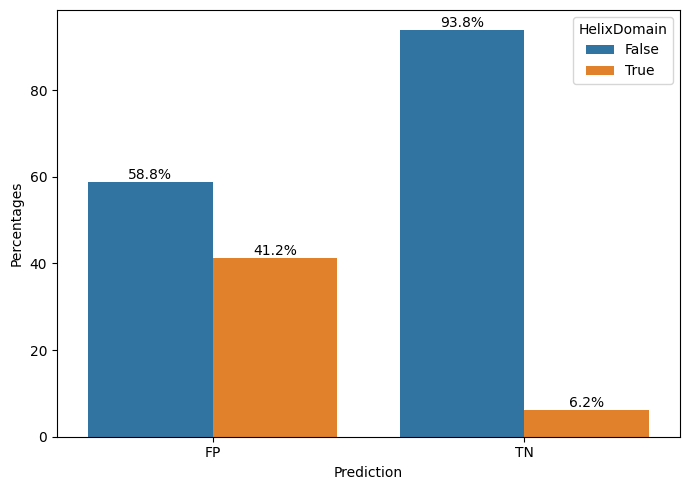

In [53]:
# make counts in function of prediction and helix domain presence
counts = (
    prediction_dataset
    .groupby(["Prediction", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)

# compute percentage within each prediction group relative to its own size
counts["percent"] = counts.groupby("Prediction")["n"].transform(lambda s: ( s / s.sum())*100)

# plot the histogram
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Prediction", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Prediction")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
    
plt.tight_layout()
plt.savefig("model_evaluation/figure1.png", dpi=300)
plt.show()


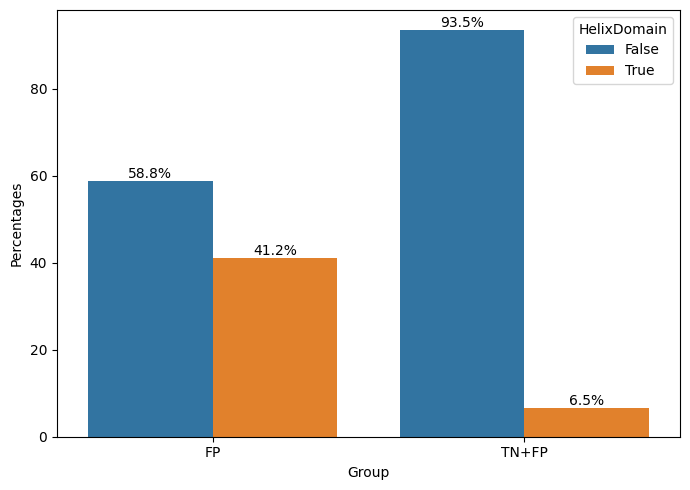

In [52]:
# create the subset with all negatives (fp+tn) and a version with only the fp

all_negatives=prediction_dataset.query("Class=='Negative'").copy()
all_negatives['Group']="TN+FP" #change this to change the label on the x-axis
false_positive=prediction_dataset.query("Prediction=='FP'").copy()
false_positive['Group']="FP" #change this to change the label on the x-axis
counts_group=pd.concat([false_positive,all_negatives], ignore_index=True)

# make counts in function of group and helix domain presence
counts = (
    counts_group
    .groupby(["Group", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)
# compute percentage within fp group and total negatives relative to its own size
counts["percent"] = counts.groupby("Group")["n"].transform(lambda s: ( s / s.sum())*100)

# make the plot
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Group", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Group")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
plt.tight_layout()
plt.savefig("model_evaluation/figure2.png", dpi=300)
plt.show()
plt.show()

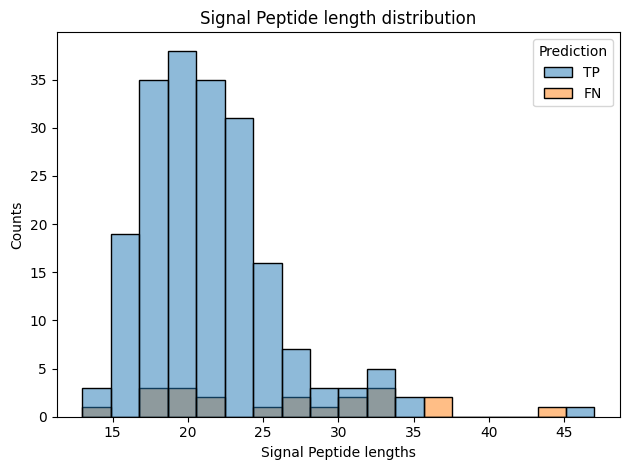

In [48]:
#signal peptide length distribution histogram
length_df = prediction_dataset.query("Class == 'Positive'").copy()
length_df["sp_length"] = prediction_dataset["SPEnd"] - prediction_dataset["SPStart"]

sns.histplot(
    data=length_df,
    x="sp_length",
    hue="Prediction",
)

plt.title("Signal Peptide length distribution")
plt.ylabel("Counts")
plt.xlabel("Signal Peptide lengths")

plt.tight_layout()
plt.savefig("model_evaluation/figure3.png", dpi=300)
plt.show()

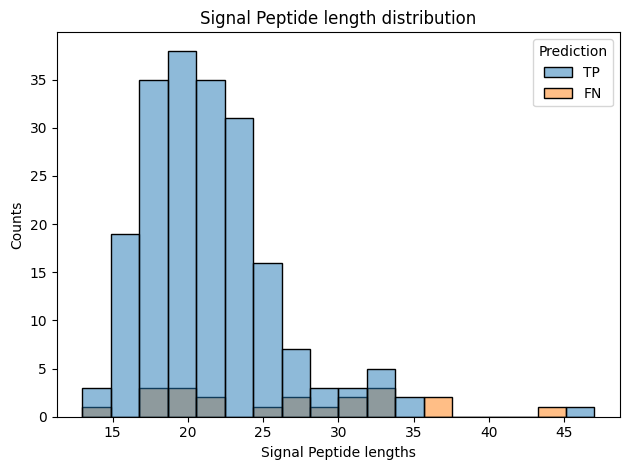

In [49]:

#signal peptide length distribution histogram
length_df = prediction_dataset.query("Class == 'Positive'").copy()
length_df["sp_length"] = prediction_dataset["SPEnd"] - prediction_dataset["SPStart"]

sns.histplot(
    data=length_df,
    x="sp_length",
    hue="Prediction",
)

plt.title("Signal Peptide length distribution")
plt.ylabel("Counts")
plt.xlabel("Signal Peptide lengths")

plt.tight_layout()
plt.savefig("model_evaluation/figure3.png", dpi=300)
plt.show()

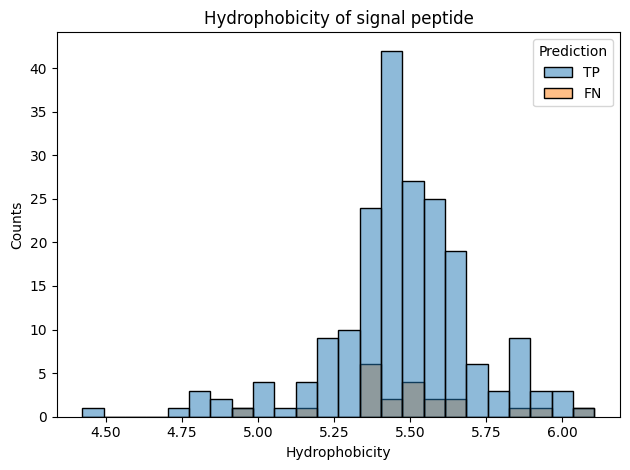

In [54]:
#hydrophobicity distribution

hydro_df = prediction_dataset.query("Class == 'Positive'").copy()

hydro_df["hydrophobicity"] = hydro_df.apply(
    lambda row: get_scale_features(row["Sequence"], "mi", int(row["SPEnd"] - row["SPStart"]) , "mean"),
    axis=1
)

sns.histplot(
    data=hydro_df,
    x="hydrophobicity",
    hue="Prediction",
    
)

plt.title("Hydrophobicity of signal peptide")
plt.ylabel("Counts")
plt.xlabel("Hydrophobicity")

plt.tight_layout()
plt.savefig("model_evaluation/figure4.png", dpi=300)
plt.show()



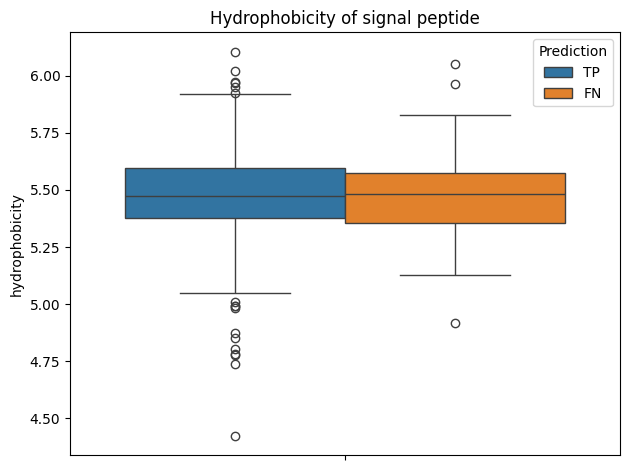

In [55]:
sns.boxplot(
    data=hydro_df,
    y="hydrophobicity",
    hue="Prediction",
    
)

plt.title("Hydrophobicity of signal peptide")
plt.tight_layout()
plt.savefig("model_evaluation/figure5.png", dpi=300)
plt.show()

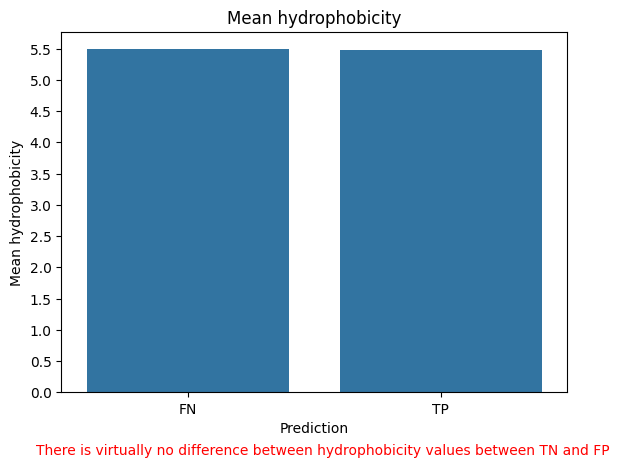


 Prediction
FN    5.492710
TP    5.470546
Name: hydrophobicity, dtype: float64 



In [56]:
# mean hydrophobicity percentage
import seaborn as sns
import matplotlib.pyplot as plt

hydro_means = hydro_df.groupby('Prediction')['hydrophobicity'].mean()

sns.barplot(x=hydro_means.index, y=hydro_means.values)

y_ticks = [i/10 for i in range(0, 60, 5)]
plt.ylabel("Mean hydrophobicity")  
plt.yticks(y_ticks)
plt.title("Mean hydrophobicity")
plt.text(-0.6, -1, "There is virtually no difference between hydrophobicity values between TN and FP", color='red', fontsize=10)
plt.tight_layout()
plt.savefig("model_evaluation/figure6.png", dpi=300)
plt.show()
print("\n", hydro_means ,"\n")

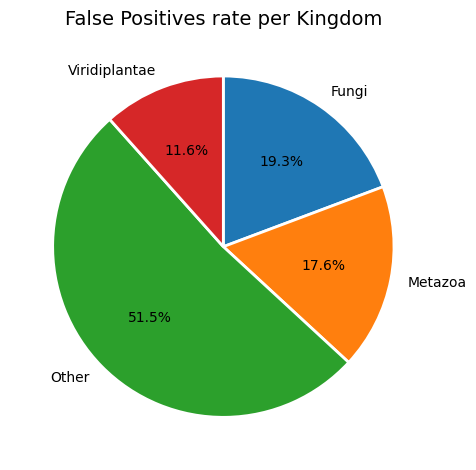

In [57]:
#pie plot with false positive for kingdom classification
false_positives=prediction_dataset.query("Prediction=='FP'")
counts_falsepositive = (
    false_positives
    .groupby(["Kingdom", "Prediction"])
    .size()
    .rename("n")
    .reset_index()
)

counts_falsepositive["total"]=counts_falsepositive["Kingdom"].map(benchmark.query("Class=='Negative'").groupby(["Kingdom"]).size())
counts_falsepositive["percent"] = counts_falsepositive.groupby("Kingdom")["n"].transform(lambda s: ( s / counts_falsepositive["total"])*100)
fig, ax = plt.subplots()
ax.pie(
    counts_falsepositive["percent"],
    labels=counts_falsepositive["Kingdom"],
    autopct="%.1f%%",
    startangle=90,            
    counterclock=False,        
    wedgeprops={"linewidth": 2, "edgecolor": "white"}
)
ax.set_title("False Positives rate per Kingdom", fontsize=14)
ax.set_aspect("equal")         
plt.tight_layout()
plt.savefig("model_evaluation/figure7.png", dpi=300)
plt.show()

In [59]:
#fpr SVM

#compute the fpr on the entire dataset
fpr_svm=len(false_positives)/len(benchmark.query("Class=='Negative'"))
fpr_helix_svm=len(false_positive.query("HelixDomain==True"))/len(benchmark.query("Class=='Negative' and HelixDomain==True"))


In [62]:
print("FPR NEURAL NETWORK:",fpr_svm)
print("FPR NEURAL NETWORK only on transmembrane proteins:", fpr_helix_svm)

FPR NEURAL NETWORK: 0.009513150531617236
FPR NEURAL NETWORK only on transmembrane proteins: 0.05982905982905983


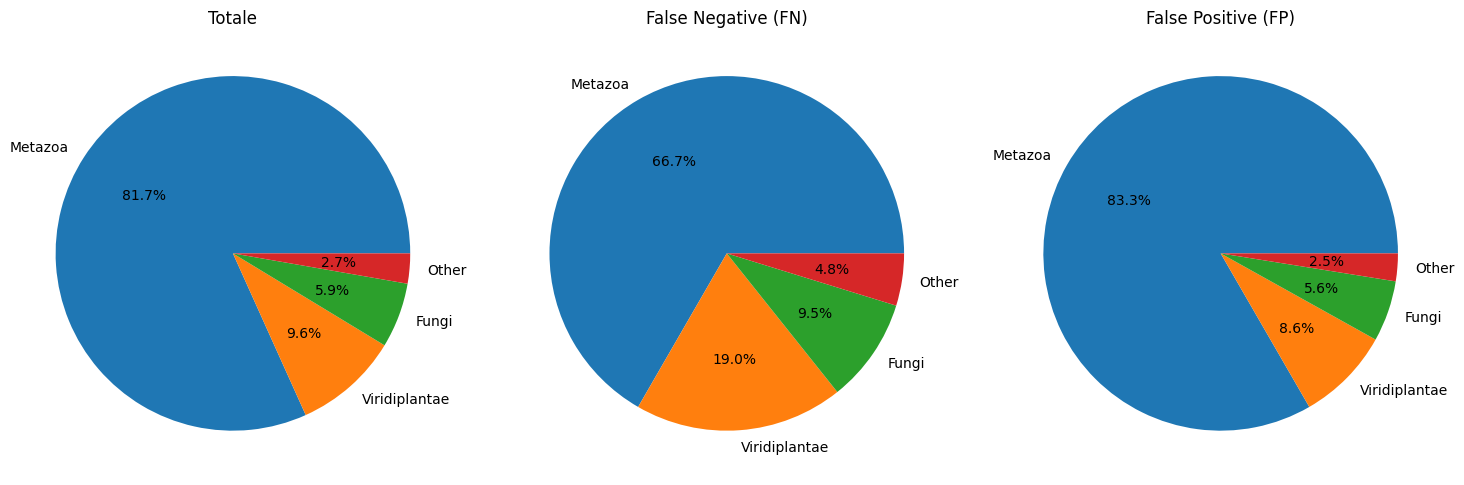

In [63]:
# Taxonomic Composition of False Negatives, False Positives and Total Predictions
taxa_df=prediction_dataset.query("Class == 'Positive'").copy()

counts_total = taxa_df['Kingdom'].value_counts()
counts_fn = taxa_df[taxa_df['Prediction'] == 'FN']['Kingdom'].value_counts()
counts_fp = taxa_df[taxa_df['Prediction'] == 'TP']['Kingdom'].value_counts()


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].pie(counts_total, labels=counts_total.index, autopct='%1.1f%%')
axes[0].set_title('Totale')

axes[1].pie(counts_fn, labels=counts_fn.index, autopct='%1.1f%%')
axes[1].set_title('False Negative (FN)')

axes[2].pie(counts_fp, labels=counts_fp.index, autopct='%1.1f%%')
axes[2].set_title('False Positive (FP)')

plt.tight_layout()
plt.savefig("model_evaluation/figure8.png", dpi=300)
plt.show()


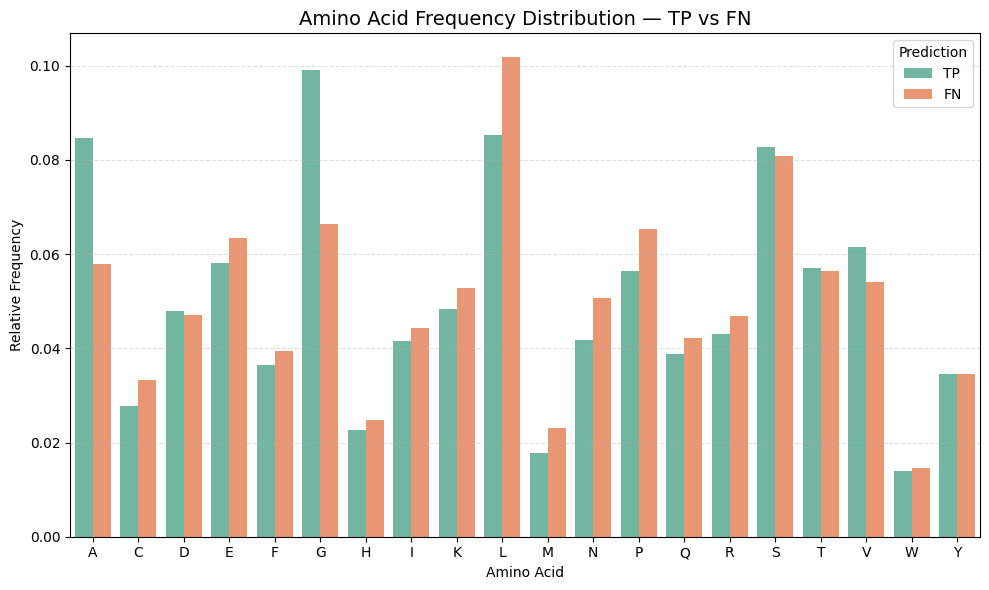

In [64]:
TP_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "TP"][["Sequence"]].copy()
FN_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FN"][["Sequence"]].copy()

def aa_frequency(df):
    all_seq = "".join(df["Sequence"])
    total = len(all_seq)
    freq = {aa: all_seq.count(aa) / total for aa in set(all_seq)}
    return pd.Series(freq).sort_index()
TP_freq = aa_frequency(TP_df_sequence)
FN_freq = aa_frequency(FN_df_sequence)



# Merge the two Pandas Series (TP_freq and FN_freq) for the plot

aa_compare = pd.DataFrame({
    "TP": TP_freq,
    "FN": FN_freq
}).fillna(0)

aa_compare = (
    aa_compare.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)



plt.figure(figsize=(10,6))
sns.barplot(
    data=aa_compare,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    palette="Set2"
)
plt.title("Amino Acid Frequency Distribution — TP vs FN", fontsize=14)
plt.xlabel("Amino Acid")
plt.ylabel("Relative Frequency")
plt.grid(axis='y', linestyle = "--", alpha = 0.4)
plt.legend(title="Prediction")
plt.savefig("model_evaluation/figure9.png", dpi=300)
plt.tight_layout()
plt.show()

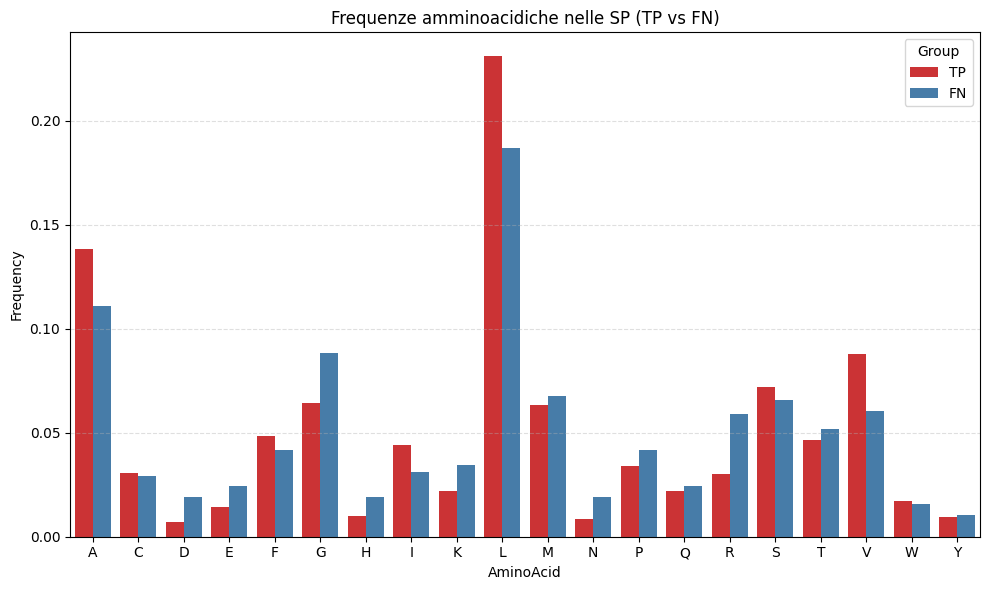

In [65]:
SP_df = prediction_dataset[prediction_dataset["Prediction"].isin(["TP", "FN"])][["SPStart", "SPEnd", "Sequence", "Prediction"]].copy()

def SP_aa_frequency(df):
    for index, row in df.iterrows():
        seq = row["Sequence"]
        start = int(row["SPStart"]) - 1
        end = int(row["SPEnd"])
        df.loc[index, "SPSequence"] = seq[start:end]
    return df

SP_df = SP_aa_frequency(SP_df)

def SP_frequency(df, label):
    label_df = df[df["Prediction"] == label]
    all_seq = "".join(label_df["SPSequence"].dropna().astype(str))
    total = len(all_seq)
    if total == 0:
        return pd.Series(dtype=float)
    unique_aa = sorted(set(all_seq))
    freq = {aa: all_seq.count(aa) / total for aa in unique_aa}
    return pd.Series(freq)


TP_ser = SP_frequency(SP_df, "TP").rename("TP")
FN_ser = SP_frequency(SP_df, "FN").rename("FN")

freq_df = pd.concat([TP_ser, FN_ser], axis=1).fillna(0)

plot_df = (
    freq_df.reset_index()
           .melt(id_vars="index", var_name="Group", value_name="Frequency")
           .rename(columns={"index": "AminoAcid"})
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    palette="Set1"
)
plt.grid(axis='y', linestyle = "--", alpha = 0.4)
plt.title("Frequenze amminoacidiche nelle SP (TP vs FN)")
plt.tight_layout()
plt.show()

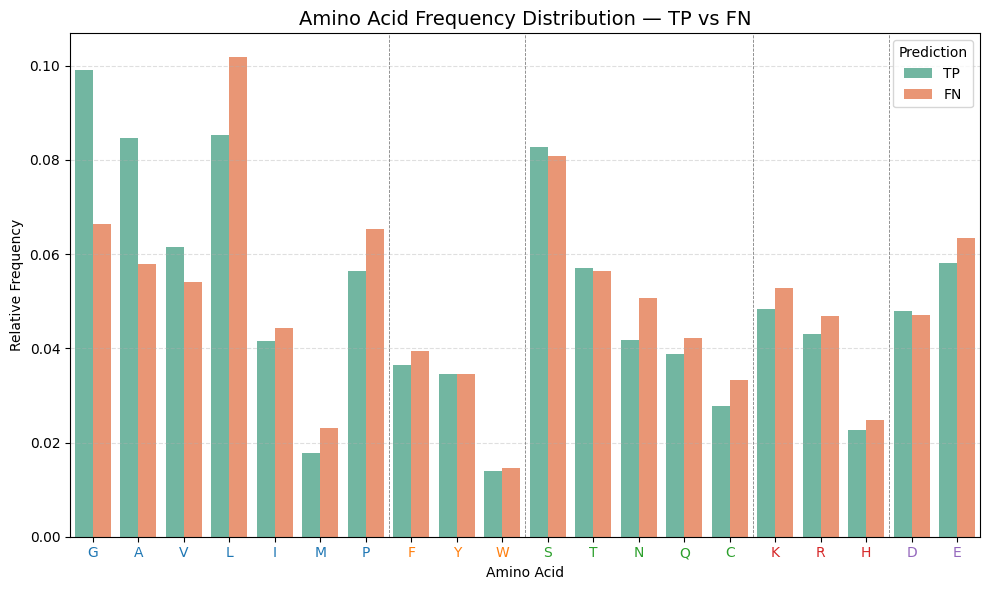

In [66]:
# TP_freq e FN_freq have to be residue-indexed Series (es. index=['A','C',...])
aa_compare = pd.DataFrame({"TP": TP_freq, "FN": FN_freq}).fillna(0)

aa_compare = (
    aa_compare.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)

aa_categories = {
    'nonpolar': list("GAVLIMP"),
    'aromatic': list("FYW"),
    'polar':    list("STNQC"),
    'positive': list("KRH"),
    'negative': list("DE"),
}

aa_order = [
    'G','A','V','L','I','M','P',
    'F','Y','W',
    'S','T','N','Q','C',
    'K','R','H',
    'D','E'
]

# mapping AA
res_to_cat = {aa: cat for cat, aas in aa_categories.items() for aa in aas}
aa_compare["AminoAcid"] = pd.Categorical(aa_compare["AminoAcid"], categories=aa_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aa_compare,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set2"
)

ax.set_title("Amino Acid Frequency Distribution — TP vs FN", fontsize=14)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Relative Frequency")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend(title="Prediction")

# label color based on category
cat_colors = {
    'nonpolar':'#1f77b4',
    'aromatic':'#ff7f0e',
    'polar':'#2ca02c',
    'positive':'#d62728',
    'negative':'#9467bd'
}
for label in ax.get_xticklabels():
    aa = label.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        label.set_color(cat_colors[cat])

# separating lines between groups
group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.show()

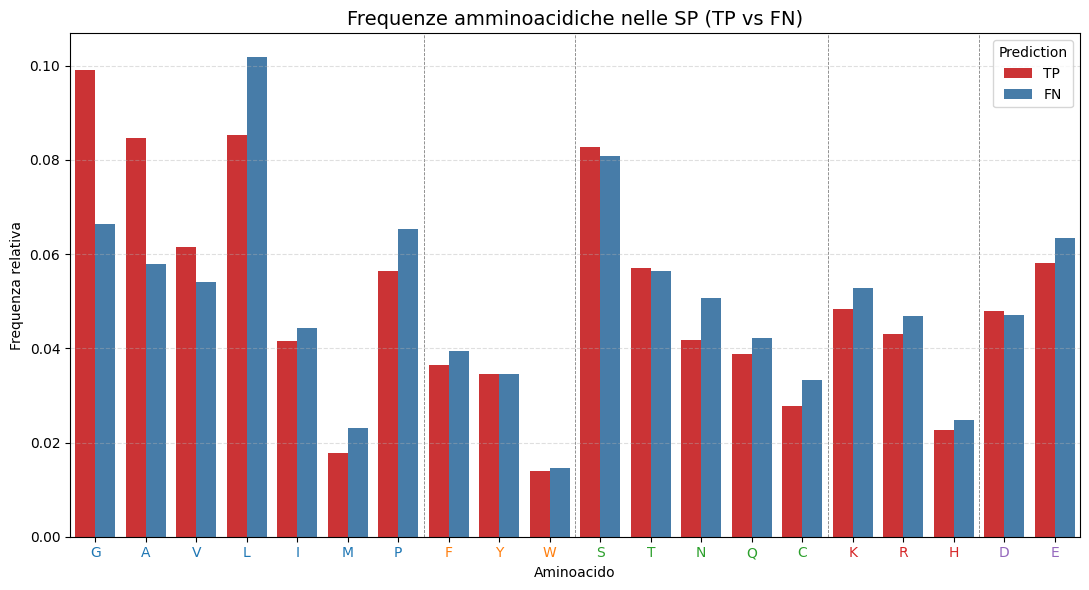

In [67]:
plt.figure(figsize=(11, 6))
ax = sns.barplot(
    data=aa_compare,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set1"
)
ax.set_title("Frequenze amminoacidiche nelle SP (TP vs FN)", fontsize=14)
ax.set_xlabel("Aminoacido")
ax.set_ylabel("Frequenza relativa")
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(title="Prediction")

# separating lines between groups
cat_colors = {
    "nonpolar":"#1f77b4",
    "aromatic":"#ff7f0e",
    "polar":"#2ca02c",
    "positive":"#d62728",
    "negative":"#9467bd"
}
for tick in ax.get_xticklabels():
    aa = tick.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        tick.set_color(cat_colors[cat])

# separating lines between categories
group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color="gray", linestyle="--", linewidth=0.6, zorder=0)
    
plt.tight_layout()
plt.savefig("model_evaluation/figure10.png", dpi=300)
plt.show()

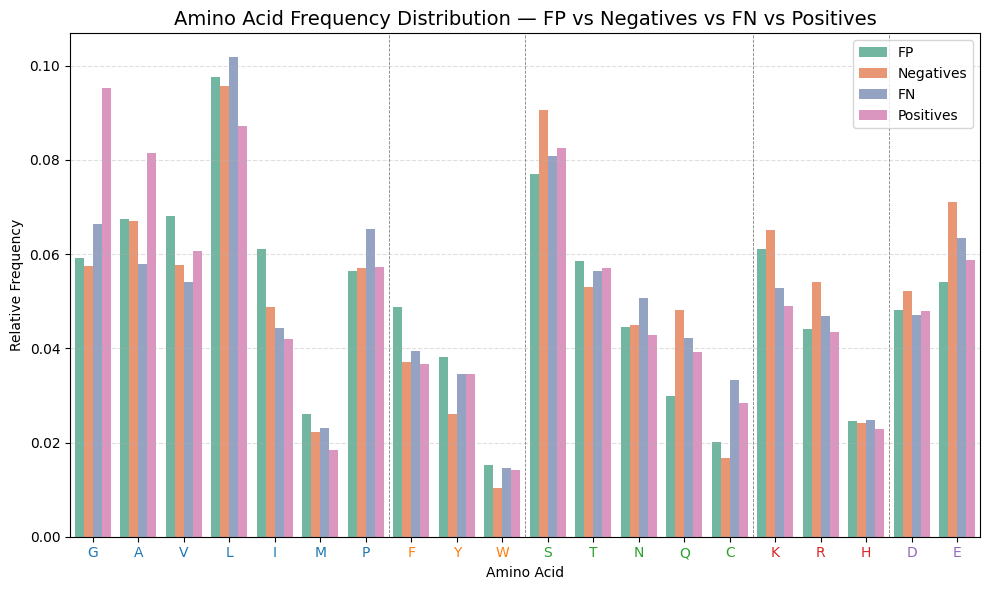

In [68]:
#we now compare aa frequencies among all positives, all negatives, false positives and false negatives
FP_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FP"][["Sequence"]].copy()
#FN_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FN"][["Sequence"]].copy()
PP_df_sequence = prediction_dataset[prediction_dataset["Class"] == "Positive"][["Sequence"]].copy()
NN_df_sequence = prediction_dataset[prediction_dataset["Class"] == "Negative"][["Sequence"]].copy()

FP_freq = aa_frequency(FP_df_sequence)
#FN_freq = aa_frequency(FN_df_sequence)
PP_freq = aa_frequency(PP_df_sequence)
NN_freq = aa_frequency(NN_df_sequence)


# TP_freq e FN_freq have to be residue-indexed Series (es. index=['A','C',...])
aa_compare_tot = pd.DataFrame({"FP": FP_freq, "Negatives" : NN_freq , "FN": FN_freq , "Positives" : PP_freq}).fillna(0)

aa_compare_tot = (
    aa_compare_tot.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)
aa_order = [
    'G','A','V','L','I','M','P',
    'F','Y','W',
    'S','T','N','Q','C',
    'K','R','H',
    'D','E'
]

# mapping AA
aa_categories = {
    'nonpolar': list("GAVLIMP"),
    'aromatic': list("FYW"),
    'polar':    list("STNQC"),
    'positive': list("KRH"),
    'negative': list("DE"),
}
cat_colors = {
    "nonpolar":"#1f77b4",
    "aromatic":"#ff7f0e",
    "polar":"#2ca02c",
    "positive":"#d62728",
    "negative":"#9467bd"
}



res_to_cat = {aa: cat for cat, aas in aa_categories.items() for aa in aas}
aa_compare_tot["AminoAcid"] = pd.Categorical(aa_compare_tot["AminoAcid"], categories=aa_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aa_compare_tot,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set2"
)

ax.set_title("Amino Acid Frequency Distribution — FP vs Negatives vs FN vs Positives", fontsize=14)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Relative Frequency")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend()

for label in ax.get_xticklabels():
    aa = label.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        label.set_color(cat_colors[cat])

group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("model_evaluation/figure9.png", dpi=300)
plt.show()

In [71]:
import logomaker as lm 

#Lets analyse FP , FN , TP , TN

#create sequence lists 
logo_pos_seqs=[]
logo_neg_seqs=[]
logo_fn_seqs=[]
logo_fp_seqs=[]


logo_neg = prediction_dataset.query("Class == 'Negative'")
#To make a logo, all sequences need to have the same length
for index,row in logo_neg.iterrows():
    sequence_to_recover=row["Sequence"]
    logo_neg_seqs.append(sequence_to_recover[1:18])
    if row["Prediction"]=="FP":
        logo_fp_seqs.append(sequence_to_recover[1:18])
    
logo_pos = prediction_dataset.query("Class == 'Positive'")
for index,row in logo_pos.iterrows():
    sequence_to_recover=row["Sequence"]
    cleavage_position=int(row["SPEnd"])
    logo_pos_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+4])
    if row["Prediction"]=="FN":
        logo_fn_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+4])

logo_fullseqs=[logo_pos_seqs ,logo_fn_seqs, logo_neg_seqs , logo_fp_seqs]



Sequence Logos computed using Information Content


C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11872146 0.08675799 0.09589041 0.11415525 0.17808219 0.16438356
 0.08219178 0.15981735 0.15525114 0.10958904 0.25114155 0.06849315
 0.51141553 0.15068493 0.05022831 0.06392694 0.0913242 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.03196347 0.03652968 0.03652968 0.04109589 0.03652968 0.0456621
 0.05936073 0.02283105 0.03196347 0.03196347 0.06849315 0.02283105
 0.02739726 0.02283105 0.01369863 0.06849315 0.03196347]' has dtype incompatible with int64, please explicitly cast to a co

<Figure size 600x1400 with 0 Axes>

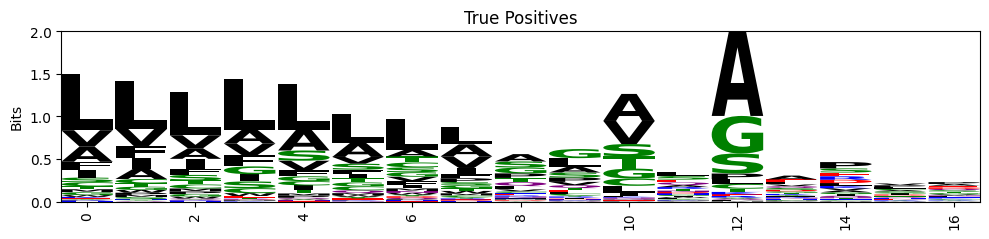

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.04761905 0.19047619 0.0952381  0.0952381  0.14285714
 0.0952381  0.19047619 0.14285714 0.0952381  0.28571429 0.04761905
 0.47619048 0.23809524 0.0952381  0.0952381  0.14285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04761905 0.04761905 0.04761905 0.04761905 0.         0.
 0.0952381  0.0952381  0.04761905 0.04761905 0.04761905 0.
 0.         0.         0.         0.14285714 0.04761905]' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

<Figure size 600x1400 with 0 Axes>

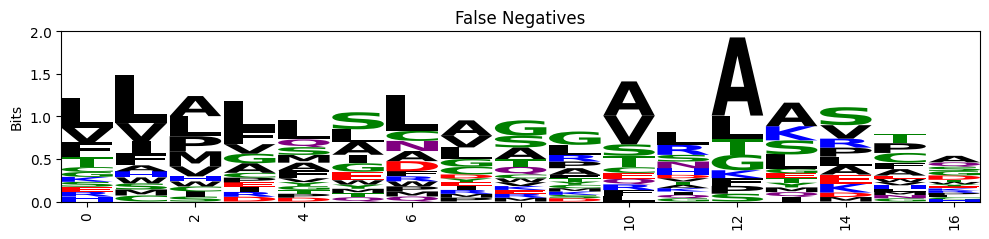

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21656407 0.10016788 0.08002238 0.08449916 0.07890319 0.07274762
 0.06771125 0.08226077 0.08170118 0.08170118 0.08058198 0.08282037
 0.06827084 0.07554561 0.08058198 0.08282037 0.07554561]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00503637 0.01063234 0.01231114 0.0184667  0.0201455  0.01790711
 0.01790711 0.01343033 0.01790711 0.0184667  0.0184667  0.01566872
 0.0184667  0.01510912 0.01678791 0.0201455  0.01063234]' has dtype incompatible with int64, please explicitly cast to a c

<Figure size 600x1400 with 0 Axes>

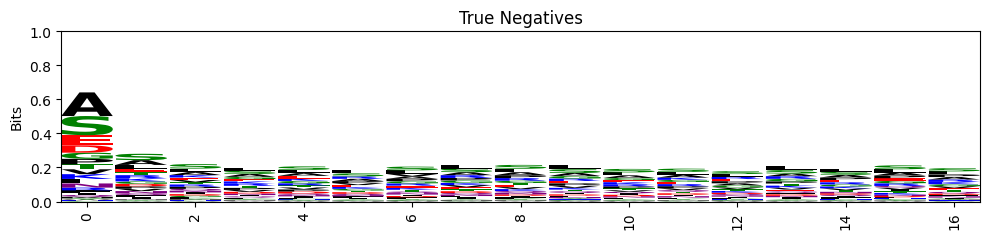

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11764706 0.11764706 0.         0.05882353 0.11764706 0.
 0.05882353 0.05882353 0.17647059 0.11764706 0.         0.11764706
 0.         0.17647059 0.17647059 0.11764706 0.05882353]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.05882353 0.11764706 0.05882353 0.11764706 0.05882353 0.05882353
 0.         0.05882353 0.         0.         0.         0.11764706
 0.         0.11764706 0.         0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatibl

<Figure size 600x1400 with 0 Axes>

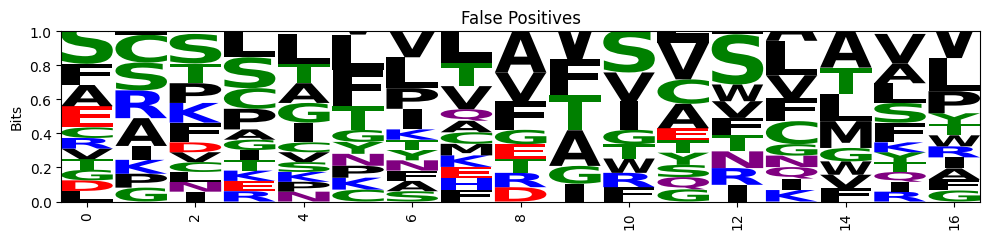

Sequence Logos computed using Probability of residues


C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11872146 0.08675799 0.09589041 0.11415525 0.17808219 0.16438356
 0.08219178 0.15981735 0.15525114 0.10958904 0.25114155 0.06849315
 0.51141553 0.15068493 0.05022831 0.06392694 0.0913242 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.03196347 0.03652968 0.03652968 0.04109589 0.03652968 0.0456621
 0.05936073 0.02283105 0.03196347 0.03196347 0.06849315 0.02283105
 0.02739726 0.02283105 0.01369863 0.06849315 0.03196347]' has dtype incompatible with int64, please explicitly cast to a co

<Figure size 600x1400 with 0 Axes>

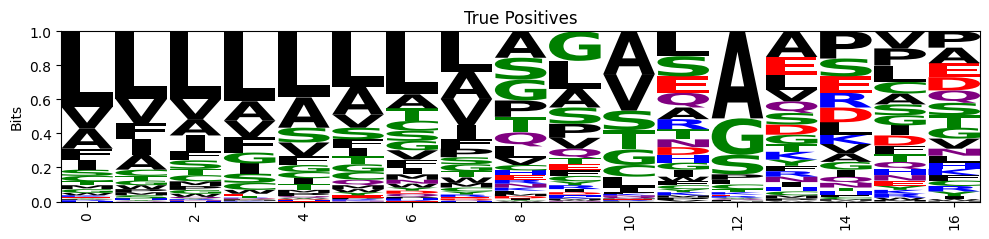

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.04761905 0.19047619 0.0952381  0.0952381  0.14285714
 0.0952381  0.19047619 0.14285714 0.0952381  0.28571429 0.04761905
 0.47619048 0.23809524 0.0952381  0.0952381  0.14285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04761905 0.04761905 0.04761905 0.04761905 0.         0.
 0.0952381  0.0952381  0.04761905 0.04761905 0.04761905 0.
 0.         0.         0.         0.14285714 0.04761905]' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

<Figure size 600x1400 with 0 Axes>

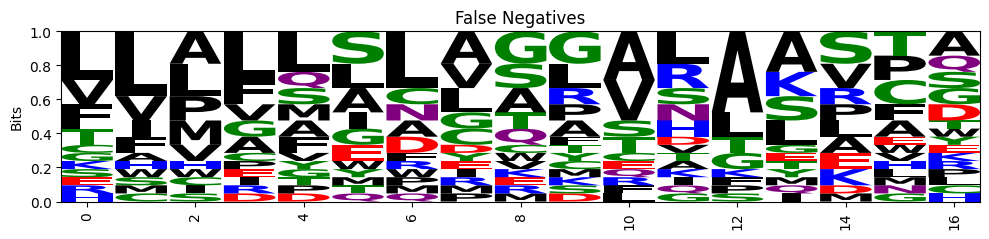

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21656407 0.10016788 0.08002238 0.08449916 0.07890319 0.07274762
 0.06771125 0.08226077 0.08170118 0.08170118 0.08058198 0.08282037
 0.06827084 0.07554561 0.08058198 0.08282037 0.07554561]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00503637 0.01063234 0.01231114 0.0184667  0.0201455  0.01790711
 0.01790711 0.01343033 0.01790711 0.0184667  0.0184667  0.01566872
 0.0184667  0.01510912 0.01678791 0.0201455  0.01063234]' has dtype incompatible with int64, please explicitly cast to a c

<Figure size 600x1400 with 0 Axes>

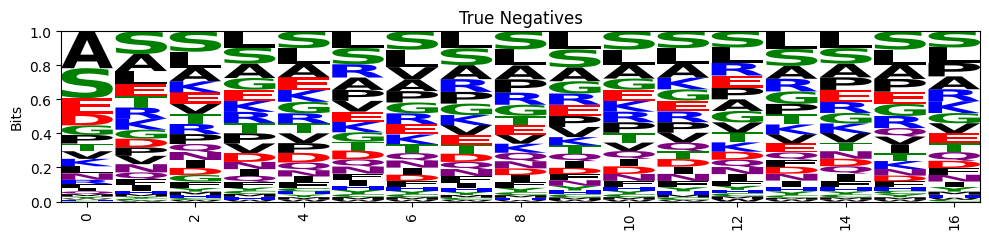

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11764706 0.11764706 0.         0.05882353 0.11764706 0.
 0.05882353 0.05882353 0.17647059 0.11764706 0.         0.11764706
 0.         0.17647059 0.17647059 0.11764706 0.05882353]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.05882353 0.11764706 0.05882353 0.11764706 0.05882353 0.05882353
 0.         0.05882353 0.         0.         0.         0.11764706
 0.         0.11764706 0.         0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatibl

<Figure size 600x1400 with 0 Axes>

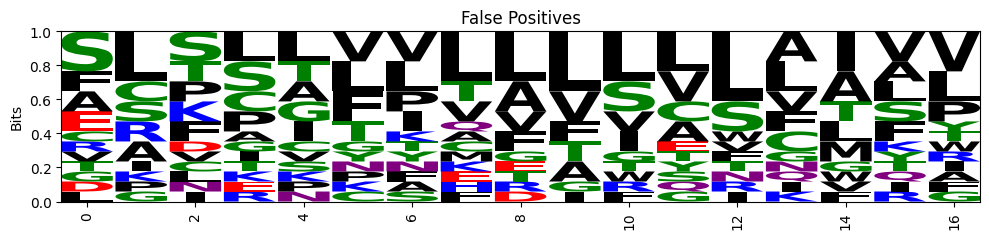

In [72]:
# Sequence logo --> metric = information content
count=1
print("Sequence Logos computed using Information Content")
for i , j in zip(logo_fullseqs , ["True Positives" , "False Negatives", "True Negatives" , "False Positives" ]):
    #create an alignment matrix
    logo_mat=lm.alignment_to_matrix(sequences=i, to_type='information',characters_to_ignore='.-X', pseudocount=0 )
    #plot the sequence logo
    plt.figure(figsize=(6,14))
    lm.Logo(logo_mat, shade_below=.5, fade_below=.5, color_scheme="chemistry")
    plt.xticks(rotation=90)
    plt.ylabel("Bits")
    if j in ["True Negatives" , "False Positives" ]:
        plt.ylim(0, 1.0)  # Adjust the maximum Y-axis limit
    else:
        plt.ylim(0, 2.0)  # Adjust the maximum Y-axis limit
    plt.title(j)
    plt.tight_layout()
    plt.savefig(f"model_evaluation/figure12A-{count}.png", dpi=300)
    plt.show()
    count=count+1

# Sequence logo --> metric = probability
count=1
print("Sequence Logos computed using Probability of residues")
for i , j in zip(logo_fullseqs , ["True Positives" , "False Negatives", "True Negatives" , "False Positives" ]):
    #create an alignment matrix
    logo_mat=lm.alignment_to_matrix(sequences=i, to_type='probability',characters_to_ignore='.-X', pseudocount=0 )
    #plot the sequence logo
    plt.figure(figsize=(6,14))
    lm.Logo(logo_mat, shade_below=.5, fade_below=.5, color_scheme="chemistry")
    plt.xticks(rotation=90)
    plt.ylabel("Bits")
    plt.title(j)
    plt.tight_layout()
    plt.savefig(f"model_evaluation/figure12B-{count}.png", dpi=300) 
    plt.show()
    count=count+1

In [73]:
# Viridaeplante analysis
plant_df = prediction_dataset.query("Kingdom == 'Viridiplantae'")
print("False Positive rate in plant entries: "+str(plant_df.query("Prediction == 'FP'").shape[0] / plant_df.query("Class == 'Negative'").shape[0]))
print("False Positive rate in entire benchmark set:" , fpr_svm)
print("\nIn total we have "+str(plant_df.shape[0])+" entries")
print("Out of all entries in plant kingdom "+str(plant_df.query("OrganismName == 'Arabidopsis thaliana'").shape[0])+" of them are from Arabidopsis")

fpr_ara = plant_df.query("OrganismName == 'Arabidopsis thaliana' and Prediction == 'FP'").shape[0] / plant_df.query("OrganismName == 'Arabidopsis thaliana' and Class == 'Negative'").shape[0]
print("False Positive rate in Arabidopsis entries:" , fpr_ara)

fpr_not = plant_df.query("OrganismName != 'Arabidopsis thaliana' and Prediction == 'FP'").shape[0] / plant_df.query("OrganismName != 'Arabidopsis thaliana' and Class == 'Negative'").shape[0]
print("False Positive rate in all other entries:", fpr_not)

False Positive rate in plant entries: 0.00625
False Positive rate in entire benchmark set: 0.009513150531617236

In total we have 341 entries
Out of all entries in plant kingdom 265 of them are from Arabidopsis
False Positive rate in Arabidopsis entries: 0.0038461538461538464
False Positive rate in all other entries: 0.016666666666666666
